In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_start = 1
pred_end = 2

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
train_input = train_input + val_input
train_output = train_output + val_output

In [22]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [23]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [24]:
RNA_s4d1 = torch.from_numpy(RNA_s4d1)
RNA_s4d8 = torch.from_numpy(RNA_s4d8)
RNA_s4d9 = torch.from_numpy(RNA_s4d9)

pro_s4d1 = torch.from_numpy(pro_s4d1)
pro_s4d8 = torch.from_numpy(pro_s4d8)
pro_s4d9 = torch.from_numpy(pro_s4d9)

In [25]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [26]:
RNA_s4d1 = RNA_s4d1.float()
RNA_s4d8 = RNA_s4d8.float()
RNA_s4d9 = RNA_s4d9.float()

pro_s4d1 = pro_s4d1.float()
pro_s4d8 = pro_s4d8.float()
pro_s4d9 = pro_s4d9.float()

In [27]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [28]:
RNA_s4d1 = RNA_s4d1.to(device)
RNA_s4d8 = RNA_s4d8.to(device)
RNA_s4d9 = RNA_s4d9.to(device)

pro_s4d1 = pro_s4d1.to(device)
pro_s4d8 = pro_s4d8.to(device)
pro_s4d9 = pro_s4d9.to(device)

In [29]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [30]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [31]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [32]:
batch_train = batch_train + batch_val

In [33]:
train_output = train_output[:, pred_start:pred_end]
train_output.shape

val_output = val_output[:, pred_start:pred_end]
val_output.shape

test_output = test_output[:, pred_start:pred_end]
test_output.shape

pro_s4d1 = pro_s4d1[:, pred_start:pred_end]
pro_s4d8 = pro_s4d8[:, pred_start:pred_end]
pro_s4d9 = pro_s4d9[:, pred_start:pred_end]

In [34]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [35]:
input_feature = train_input.shape[1]
output_feature = pred_end-pred_start

In [36]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, output_feature)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, output_feature)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [37]:
PATH = 'Auto_No_norm_model_RNA_pro_' + str(pred_end-pred_start) + '.pth'

In [38]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            s4d1_pred = model(RNA_s4d1)
            s4d1_loss = loss_fn(s4d1_pred, pro_s4d1)
            s4d1_loss = torch.sqrt(s4d1_loss)
            s4d1_loss = s4d1_loss.cpu().detach().numpy()
            
            s4d8_pred = model(RNA_s4d8)
            s4d8_loss = loss_fn(s4d8_pred, pro_s4d8)
            s4d8_loss = torch.sqrt(s4d8_loss)
            s4d8_loss = s4d8_loss.cpu().detach().numpy()
            
            s4d9_pred = model(RNA_s4d9)
            s4d9_loss = loss_fn(s4d9_pred, pro_s4d9)
            s4d9_loss = torch.sqrt(s4d9_loss)
            s4d9_loss = s4d9_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            cal_test_loss = ((s4d1_loss**2*s4d1_pred.shape[0] + s4d8_loss**2*s4d8_pred.shape[0] + s4d9_loss**2*s4d9_pred.shape[0])/(s4d1_pred.shape[0]+s4d8_pred.shape[0]+s4d9_pred.shape[0]))**0.5
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch', epoch, 'Train_loss:', train_loss, ' Validation_loss:', val_loss, ' Test_loss:', test_loss, 's4d1 loss:', s4d1_loss, 's4d8 loss:', s4d8_loss, 's4d9_loss:', s4d9_loss, 'test loss:', test_loss, 'cal test', cal_test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch 0 Train_loss: 0.48937804  Validation_loss: 0.33105072  Test_loss: 0.64723474 s4d1 loss: 0.23609418 s4d8 loss: 0.28481644 s4d9_loss: 0.91406775 test loss: 0.64723474 cal test 0.647234771806994


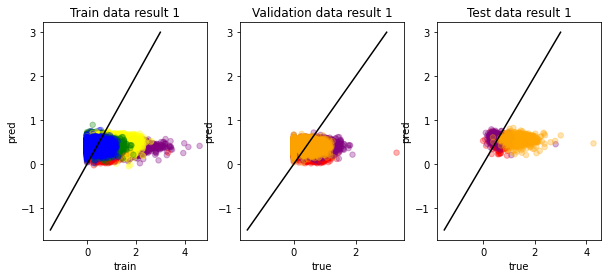

Epoch 100 Train_loss: 0.3792568  Validation_loss: 0.2880453  Test_loss: 0.6128616 s4d1 loss: 0.22555695 s4d8 loss: 0.27526936 s4d9_loss: 0.86435294 test loss: 0.6128616 cal test 0.6128615511203559
Epoch 200 Train_loss: 0.36385086  Validation_loss: 0.28175732  Test_loss: 0.6125727 s4d1 loss: 0.22158916 s4d8 loss: 0.27798513 s4d9_loss: 0.8642617 test loss: 0.6125727 cal test 0.6125726951428528
Epoch 300 Train_loss: 0.35409117  Validation_loss: 0.27964628  Test_loss: 0.61516947 s4d1 loss: 0.22452076 s4d8 loss: 0.2802555 s4d9_loss: 0.8673931 test loss: 0.61516947 cal test 0.6151694176305964
Epoch 400 Train_loss: 0.34666663  Validation_loss: 0.2764845  Test_loss: 0.6259476 s4d1 loss: 0.22810537 s4d8 loss: 0.28587386 s4d9_loss: 0.88255274 test loss: 0.6259476 cal test 0.6259475680820884
Epoch 500 Train_loss: 0.34042403  Validation_loss: 0.274166  Test_loss: 0.63155526 s4d1 loss: 0.23102498 s4d8 loss: 0.28880036 s4d9_loss: 0.8902407 test loss: 0.63155526 cal test 0.6315552321069628
Epoch 600 

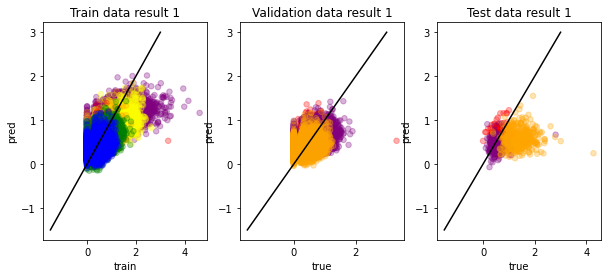

Epoch 1100 Train_loss: 0.3094226  Validation_loss: 0.25824052  Test_loss: 0.64237523 s4d1 loss: 0.24343324 s4d8 loss: 0.29589987 s4d9_loss: 0.9035501 test loss: 0.64237523 cal test 0.6423751650477106
Epoch 1200 Train_loss: 0.30454186  Validation_loss: 0.25533998  Test_loss: 0.6420461 s4d1 loss: 0.24577409 s4d8 loss: 0.29678494 s4d9_loss: 0.9024477 test loss: 0.6420461 cal test 0.6420460415132184
Epoch 1300 Train_loss: 0.29959938  Validation_loss: 0.25195384  Test_loss: 0.644859 s4d1 loss: 0.24823396 s4d8 loss: 0.29918984 s4d9_loss: 0.90596247 test loss: 0.644859 cal test 0.6448590063948235
Epoch 1400 Train_loss: 0.29468876  Validation_loss: 0.24831724  Test_loss: 0.6522118 s4d1 loss: 0.25146884 s4d8 loss: 0.30340418 s4d9_loss: 0.91609186 test loss: 0.6522118 cal test 0.6522117447379326
Epoch 1500 Train_loss: 0.28973648  Validation_loss: 0.24571417  Test_loss: 0.64505273 s4d1 loss: 0.25345713 s4d8 loss: 0.30148438 s4d9_loss: 0.9048668 test loss: 0.64505273 cal test 0.6450526921413527
Ep

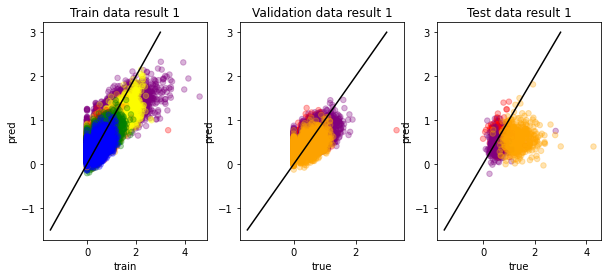

Epoch 2100 Train_loss: 0.2586254  Validation_loss: 0.22329308  Test_loss: 0.659625 s4d1 loss: 0.26966128 s4d8 loss: 0.31494135 s4d9_loss: 0.9221147 test loss: 0.659625 cal test 0.6596249694645748
Epoch 2200 Train_loss: 0.2532657  Validation_loss: 0.21928865  Test_loss: 0.66145873 s4d1 loss: 0.27201504 s4d8 loss: 0.31704533 s4d9_loss: 0.92414606 test loss: 0.66145873 cal test 0.661458721914828
Epoch 2300 Train_loss: 0.2478728  Validation_loss: 0.21552716  Test_loss: 0.6587439 s4d1 loss: 0.27404225 s4d8 loss: 0.3172105 s4d9_loss: 0.91944796 test loss: 0.6587439 cal test 0.6587438636347851
Epoch 2400 Train_loss: 0.24239746  Validation_loss: 0.21126719  Test_loss: 0.65937567 s4d1 loss: 0.2760505 s4d8 loss: 0.3191952 s4d9_loss: 0.9196876 test loss: 0.65937567 cal test 0.6593756373626105
Epoch 2500 Train_loss: 0.23693456  Validation_loss: 0.20721956  Test_loss: 0.66021216 s4d1 loss: 0.2780509 s4d8 loss: 0.3207492 s4d9_loss: 0.9203125 test loss: 0.66021216 cal test 0.6602121419213443
Epoch 26

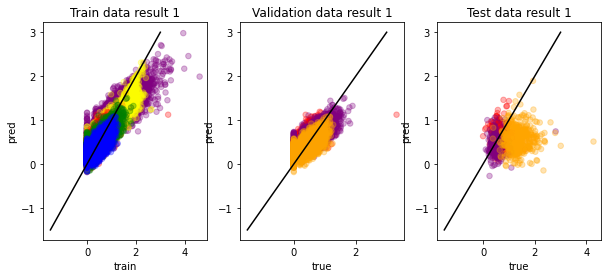

Epoch 3100 Train_loss: 0.20363583  Validation_loss: 0.18108103  Test_loss: 0.66385996 s4d1 loss: 0.28875217 s4d8 loss: 0.3287956 s4d9_loss: 0.92234874 test loss: 0.66385996 cal test 0.6638599491538443
Epoch 3200 Train_loss: 0.19820562  Validation_loss: 0.1768377  Test_loss: 0.6630127 s4d1 loss: 0.29024968 s4d8 loss: 0.32955053 s4d9_loss: 0.9205557 test loss: 0.6630127 cal test 0.6630126748041298
Epoch 3300 Train_loss: 0.19252415  Validation_loss: 0.1719082  Test_loss: 0.6696274 s4d1 loss: 0.2919344 s4d8 loss: 0.3332188 s4d9_loss: 0.9299557 test loss: 0.6696274 cal test 0.6696274103106518
Epoch 3400 Train_loss: 0.18717891  Validation_loss: 0.16784537  Test_loss: 0.6657547 s4d1 loss: 0.29325587 s4d8 loss: 0.3327413 s4d9_loss: 0.92365104 test loss: 0.6657547 cal test 0.665754665860356
Epoch 3500 Train_loss: 0.181703  Validation_loss: 0.1632624  Test_loss: 0.668646 s4d1 loss: 0.29472008 s4d8 loss: 0.33458063 s4d9_loss: 0.9275541 test loss: 0.668646 cal test 0.6686458927521385
Epoch 3600 Tr

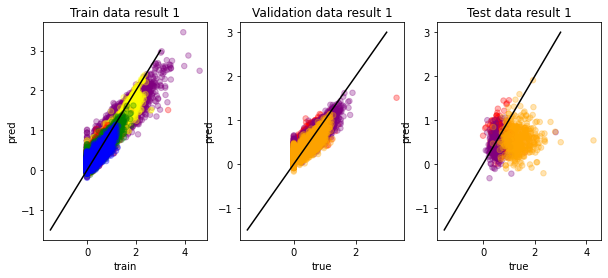

Epoch 4100 Train_loss: 0.1509295  Validation_loss: 0.13801678  Test_loss: 0.6706998 s4d1 loss: 0.30234826 s4d8 loss: 0.3410635 s4d9_loss: 0.9279332 test loss: 0.6706998 cal test 0.6706997410583888
Epoch 4200 Train_loss: 0.14606303  Validation_loss: 0.13383126  Test_loss: 0.67585474 s4d1 loss: 0.30375513 s4d8 loss: 0.34384167 s4d9_loss: 0.93525636 test loss: 0.67585474 cal test 0.6758547198869799
Epoch 4300 Train_loss: 0.14137028  Validation_loss: 0.12998106  Test_loss: 0.67508453 s4d1 loss: 0.304983 s4d8 loss: 0.34461027 s4d9_loss: 0.93362474 test loss: 0.67508453 cal test 0.6750845495392208
Epoch 4400 Train_loss: 0.13680957  Validation_loss: 0.12610608  Test_loss: 0.6762026 s4d1 loss: 0.30609745 s4d8 loss: 0.34578696 s4d9_loss: 0.9349249 test loss: 0.6762026 cal test 0.6762025430215681
Epoch 4500 Train_loss: 0.13247406  Validation_loss: 0.12241431  Test_loss: 0.6793424 s4d1 loss: 0.30700305 s4d8 loss: 0.34817788 s4d9_loss: 0.9392577 test loss: 0.6793424 cal test 0.6793423682658571
Epo

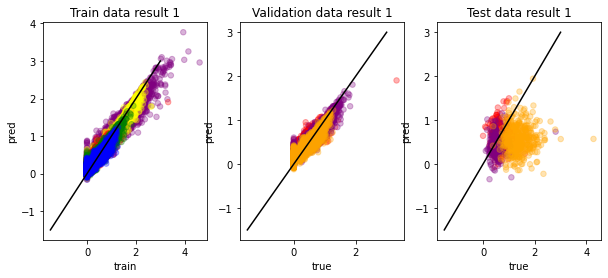

Epoch 5100 Train_loss: 0.10864267  Validation_loss: 0.102649905  Test_loss: 0.6713407 s4d1 loss: 0.31162584 s4d8 loss: 0.34936094 s4d9_loss: 0.9253138 test loss: 0.6713407 cal test 0.6713406816602512
Epoch 5200 Train_loss: 0.10504749  Validation_loss: 0.09958487  Test_loss: 0.6720602 s4d1 loss: 0.3123851 s4d8 loss: 0.35032004 s4d9_loss: 0.9261015 test loss: 0.6720602 cal test 0.6720601717253969
Epoch 5300 Train_loss: 0.10141529  Validation_loss: 0.09643092  Test_loss: 0.6744847 s4d1 loss: 0.3129599 s4d8 loss: 0.35178465 s4d9_loss: 0.9295437 test loss: 0.6744847 cal test 0.674484720762624
Epoch 5400 Train_loss: 0.09820961  Validation_loss: 0.09375586  Test_loss: 0.673931 s4d1 loss: 0.313591 s4d8 loss: 0.35252804 s4d9_loss: 0.9283862 test loss: 0.673931 cal test 0.6739310208857512
Epoch 5500 Train_loss: 0.09534328  Validation_loss: 0.09131009  Test_loss: 0.67123413 s4d1 loss: 0.3141074 s4d8 loss: 0.3516664 s4d9_loss: 0.9241402 test loss: 0.67123413 cal test 0.6712341290667535
Epoch 5600 

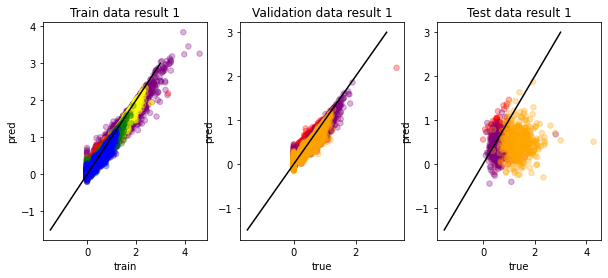

Epoch 6100 Train_loss: 0.0787933  Validation_loss: 0.07666704  Test_loss: 0.68667144 s4d1 loss: 0.31743124 s4d8 loss: 0.3607963 s4d9_loss: 0.94617325 test loss: 0.68667144 cal test 0.686671414387585
Epoch 6200 Train_loss: 0.10867955  Validation_loss: 0.09900685  Test_loss: 0.74311197 s4d1 loss: 0.33540142 s4d8 loss: 0.39411658 s4d9_loss: 1.0252683 test loss: 0.74311197 cal test 0.7431118923126891
Epoch 6300 Train_loss: 0.075814754  Validation_loss: 0.07349004  Test_loss: 0.6864733 s4d1 loss: 0.31675687 s4d8 loss: 0.35976303 s4d9_loss: 0.946202 test loss: 0.6864733 cal test 0.6864733215641212
Epoch 6400 Train_loss: 0.1449404  Validation_loss: 0.13082284  Test_loss: 0.6008332 s4d1 loss: 0.34793276 s4d8 loss: 0.35550466 s4d9_loss: 0.8008792 test loss: 0.6008332 cal test 0.6008332054183901
Epoch 6500 Train_loss: 0.09145677  Validation_loss: 0.08534953  Test_loss: 0.72615045 s4d1 loss: 0.32877597 s4d8 loss: 0.38383663 s4d9_loss: 1.0018433 test loss: 0.72615045 cal test 0.7261504440366903
Ep

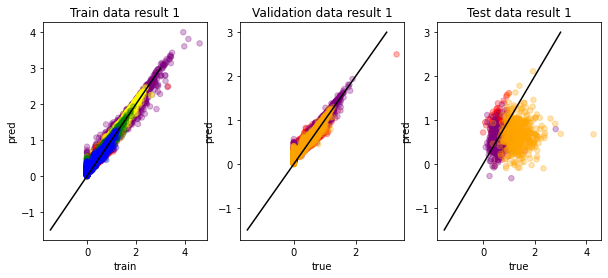

Epoch 7100 Train_loss: 0.06626615  Validation_loss: 0.064956486  Test_loss: 0.70350516 s4d1 loss: 0.32285023 s4d8 loss: 0.37117445 s4d9_loss: 0.9696792 test loss: 0.70350516 cal test 0.703505172291763
Epoch 7200 Train_loss: 0.06836637  Validation_loss: 0.0647998  Test_loss: 0.71016616 s4d1 loss: 0.32490453 s4d8 loss: 0.37561885 s4d9_loss: 0.97894216 test loss: 0.71016616 cal test 0.710166179799488
Epoch 7300 Train_loss: 0.055972014  Validation_loss: 0.056421436  Test_loss: 0.6834246 s4d1 loss: 0.31967458 s4d8 loss: 0.36224002 s4d9_loss: 0.9402347 test loss: 0.6834246 cal test 0.6834245557065046
Epoch 7400 Train_loss: 0.075183295  Validation_loss: 0.07353375  Test_loss: 0.6481002 s4d1 loss: 0.31841588 s4d8 loss: 0.34833568 s4d9_loss: 0.88690925 test loss: 0.6481002 cal test 0.6481001624111516
Epoch 7500 Train_loss: 0.09463568  Validation_loss: 0.08701409  Test_loss: 0.62827504 s4d1 loss: 0.33105886 s4d8 loss: 0.3516309 s4d9_loss: 0.8511542 test loss: 0.62827504 cal test 0.62827500864494

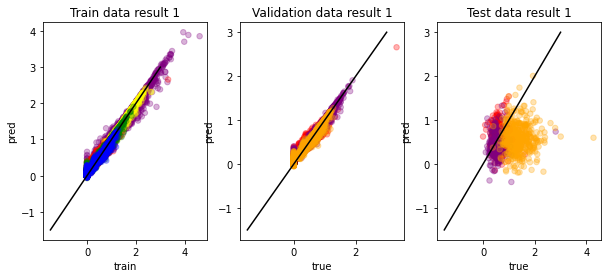

Epoch 8100 Train_loss: 0.05602507  Validation_loss: 0.05550559  Test_loss: 0.6595607 s4d1 loss: 0.32101607 s4d8 loss: 0.35413662 s4d9_loss: 0.90344375 test loss: 0.6595607 cal test 0.6595606549193905
Epoch 8200 Train_loss: 0.06438761  Validation_loss: 0.06096818  Test_loss: 0.6495324 s4d1 loss: 0.3254424 s4d8 loss: 0.35426462 s4d9_loss: 0.8862767 test loss: 0.6495324 cal test 0.6495323914762647
Epoch 8300 Train_loss: 0.04298651  Validation_loss: 0.04421253  Test_loss: 0.6887837 s4d1 loss: 0.3231088 s4d8 loss: 0.36746186 s4d9_loss: 0.94696254 test loss: 0.6887837 cal test 0.6887836890237384
Epoch 8400 Train_loss: 0.045602124  Validation_loss: 0.04611038  Test_loss: 0.6963755 s4d1 loss: 0.32328987 s4d8 loss: 0.36975104 s4d9_loss: 0.95854163 test loss: 0.6963755 cal test 0.6963754668909541
Epoch 8500 Train_loss: 0.065055855  Validation_loss: 0.06048647  Test_loss: 0.7229515 s4d1 loss: 0.3316476 s4d8 loss: 0.38595167 s4d9_loss: 0.995729 test loss: 0.7229515 cal test 0.7229514319202928
Epoc

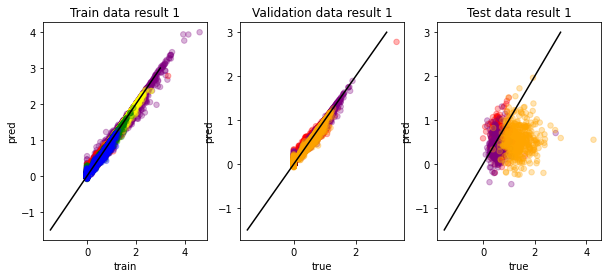

Epoch 9100 Train_loss: 0.03578566  Validation_loss: 0.03721297  Test_loss: 0.67893416 s4d1 loss: 0.32337984 s4d8 loss: 0.36313957 s4d9_loss: 0.9320329 test loss: 0.67893416 cal test 0.678934170068741
Epoch 9200 Train_loss: 0.04500981  Validation_loss: 0.04439183  Test_loss: 0.6631492 s4d1 loss: 0.32419163 s4d8 loss: 0.35849053 s4d9_loss: 0.907558 test loss: 0.6631492 cal test 0.663149175468399
Epoch 9300 Train_loss: 0.036424965  Validation_loss: 0.0374324  Test_loss: 0.6726142 s4d1 loss: 0.32372227 s4d8 loss: 0.36170352 s4d9_loss: 0.92216265 test loss: 0.6726142 cal test 0.6726141704573853
Epoch 9400 Train_loss: 0.03723065  Validation_loss: 0.037580565  Test_loss: 0.6702517 s4d1 loss: 0.32368588 s4d8 loss: 0.3608751 s4d9_loss: 0.9185638 test loss: 0.6702517 cal test 0.6702517362987946
Epoch 9500 Train_loss: 0.036560632  Validation_loss: 0.03717164  Test_loss: 0.67128795 s4d1 loss: 0.3243937 s4d8 loss: 0.36193258 s4d9_loss: 0.91984206 test loss: 0.67128795 cal test 0.6712879280677868
Ep

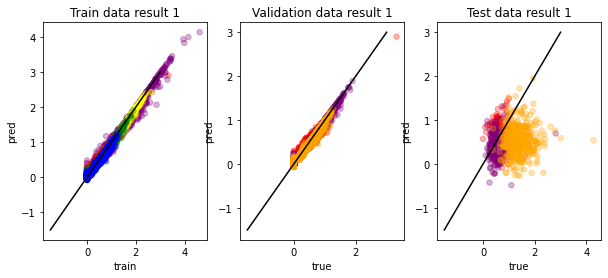

Epoch 10100 Train_loss: 0.030015443  Validation_loss: 0.031342614  Test_loss: 0.6926244 s4d1 loss: 0.3254977 s4d8 loss: 0.37021822 s4d9_loss: 0.9519729 test loss: 0.6926244 cal test 0.6926243285545237
Epoch 10200 Train_loss: 0.034837164  Validation_loss: 0.034808528  Test_loss: 0.7005867 s4d1 loss: 0.3270684 s4d8 loss: 0.37437403 s4d9_loss: 0.9634724 test loss: 0.7005867 cal test 0.7005866165200382
Epoch 10300 Train_loss: 0.030610563  Validation_loss: 0.031821884  Test_loss: 0.6745513 s4d1 loss: 0.32410553 s4d8 loss: 0.36254168 s4d9_loss: 0.9249945 test loss: 0.6745513 cal test 0.6745512700418052
Epoch 10400 Train_loss: 0.035466604  Validation_loss: 0.035549905  Test_loss: 0.6677767 s4d1 loss: 0.32435647 s4d8 loss: 0.36026943 s4d9_loss: 0.9145629 test loss: 0.6677767 cal test 0.6677767101206534
Epoch 10500 Train_loss: 0.035510812  Validation_loss: 0.034130275  Test_loss: 0.7027852 s4d1 loss: 0.32709593 s4d8 loss: 0.37532198 s4d9_loss: 0.96678203 test loss: 0.7027852 cal test 0.70278518

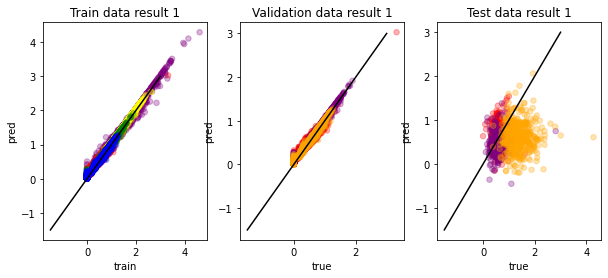

Epoch 11100 Train_loss: 0.023791766  Validation_loss: 0.02484436  Test_loss: 0.6908428 s4d1 loss: 0.3263098 s4d8 loss: 0.370622 s4d9_loss: 0.9488744 test loss: 0.6908428 cal test 0.6908428237651031
Epoch 11200 Train_loss: 0.031729937  Validation_loss: 0.031077977  Test_loss: 0.66867375 s4d1 loss: 0.32655784 s4d8 loss: 0.36257535 s4d9_loss: 0.9150096 test loss: 0.66867375 cal test 0.6686737080644846
Epoch 11300 Train_loss: 0.02298574  Validation_loss: 0.024108872  Test_loss: 0.6922373 s4d1 loss: 0.32691792 s4d8 loss: 0.37174723 s4d9_loss: 0.95073587 test loss: 0.6922373 cal test 0.6922372727334852
Epoch 11400 Train_loss: 0.031036919  Validation_loss: 0.030395672  Test_loss: 0.702289 s4d1 loss: 0.32867098 s4d8 loss: 0.37662712 s4d9_loss: 0.96537775 test loss: 0.702289 cal test 0.7022889241788165
Epoch 11500 Train_loss: 0.02395607  Validation_loss: 0.024690485  Test_loss: 0.6945466 s4d1 loss: 0.3272933 s4d8 loss: 0.37290278 s4d9_loss: 0.95410115 test loss: 0.6945466 cal test 0.69454655380

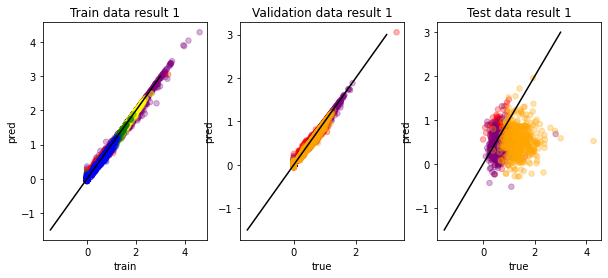

Epoch 12100 Train_loss: 0.026893886  Validation_loss: 0.026210466  Test_loss: 0.67106134 s4d1 loss: 0.32718232 s4d8 loss: 0.36405337 s4d9_loss: 0.9183846 test loss: 0.67106134 cal test 0.6710613521798112
Epoch 12200 Train_loss: 0.044789378  Validation_loss: 0.040281978  Test_loss: 0.7174192 s4d1 loss: 0.33308345 s4d8 loss: 0.38546303 s4d9_loss: 0.9867073 test loss: 0.7174192 cal test 0.7174192158773236
Epoch 12300 Train_loss: 0.01943341  Validation_loss: 0.02034175  Test_loss: 0.69131607 s4d1 loss: 0.32748145 s4d8 loss: 0.37162653 s4d9_loss: 0.9491544 test loss: 0.69131607 cal test 0.6913160590921786
Epoch 12400 Train_loss: 0.020344267  Validation_loss: 0.021068515  Test_loss: 0.67778724 s4d1 loss: 0.32733876 s4d8 loss: 0.3668483 s4d9_loss: 0.928547 test loss: 0.67778724 cal test 0.6777872192272623
Epoch 12500 Train_loss: 0.019318955  Validation_loss: 0.020082198  Test_loss: 0.69333416 s4d1 loss: 0.32826635 s4d8 loss: 0.37326205 s4d9_loss: 0.95187074 test loss: 0.69333416 cal test 0.69

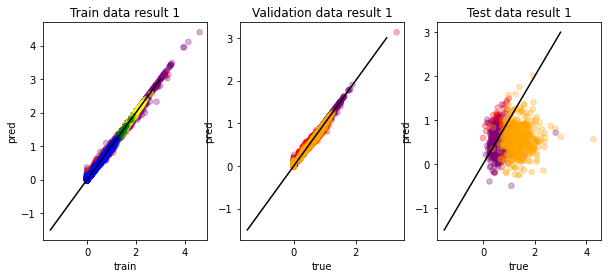

Epoch 13100 Train_loss: 0.017057754  Validation_loss: 0.017930891  Test_loss: 0.67964315 s4d1 loss: 0.32737082 s4d8 loss: 0.36754307 s4d9_loss: 0.93136615 test loss: 0.67964315 cal test 0.6796431587926756
Epoch 13200 Train_loss: 0.029431112  Validation_loss: 0.027289407  Test_loss: 0.7054172 s4d1 loss: 0.33056256 s4d8 loss: 0.3792683 s4d9_loss: 0.9694022 test loss: 0.7054172 cal test 0.705417217641038
Epoch 13300 Train_loss: 0.026658565  Validation_loss: 0.02487298  Test_loss: 0.66917807 s4d1 loss: 0.32768524 s4d8 loss: 0.3636881 s4d9_loss: 0.91532046 test loss: 0.66917807 cal test 0.6691780820073199
Epoch 13400 Train_loss: 0.020497946  Validation_loss: 0.02009454  Test_loss: 0.69730145 s4d1 loss: 0.32927984 s4d8 loss: 0.37555212 s4d9_loss: 0.9575069 test loss: 0.69730145 cal test 0.6973014439911329
Epoch 13500 Train_loss: 0.029398328  Validation_loss: 0.027506553  Test_loss: 0.6673798 s4d1 loss: 0.32819113 s4d8 loss: 0.36364475 s4d9_loss: 0.9123309 test loss: 0.6673798 cal test 0.6673

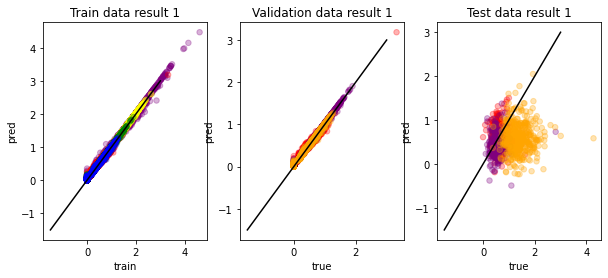

Epoch 14100 Train_loss: 0.017255573  Validation_loss: 0.017211739  Test_loss: 0.6774623 s4d1 loss: 0.32813302 s4d8 loss: 0.3674323 s4d9_loss: 0.92772186 test loss: 0.6774623 cal test 0.6774622355076245
Epoch 14200 Train_loss: 0.012430403  Validation_loss: 0.013692995  Test_loss: 0.68757445 s4d1 loss: 0.3283311 s4d8 loss: 0.37126064 s4d9_loss: 0.94306463 test loss: 0.68757445 cal test 0.6875744504281016
Epoch 14300 Train_loss: 0.02051289  Validation_loss: 0.019701742  Test_loss: 0.67421865 s4d1 loss: 0.32831234 s4d8 loss: 0.36632344 s4d9_loss: 0.9227119 test loss: 0.67421865 cal test 0.6742186554503126
Epoch 14400 Train_loss: 0.011950065  Validation_loss: 0.013159217  Test_loss: 0.6875265 s4d1 loss: 0.32851276 s4d8 loss: 0.37135997 s4d9_loss: 0.9429248 test loss: 0.6875265 cal test 0.6875264981646898
Epoch 14500 Train_loss: 0.016020933  Validation_loss: 0.015980894  Test_loss: 0.6947125 s4d1 loss: 0.32937962 s4d8 loss: 0.37474403 s4d9_loss: 0.9535163 test loss: 0.6947125 cal test 0.6947

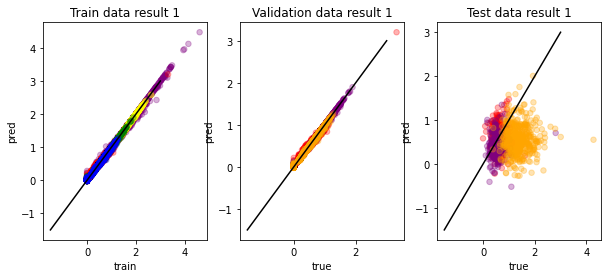

Epoch 15100 Train_loss: 0.038412478  Validation_loss: 0.03445546  Test_loss: 0.6598506 s4d1 loss: 0.33025762 s4d8 loss: 0.36245283 s4d9_loss: 0.89998716 test loss: 0.6598506 cal test 0.6598506017790337
Epoch 15200 Train_loss: 0.016237685  Validation_loss: 0.01594539  Test_loss: 0.6953724 s4d1 loss: 0.3294573 s4d8 loss: 0.37497497 s4d9_loss: 0.95450336 test loss: 0.6953724 cal test 0.695372379671334
Epoch 15300 Train_loss: 0.015712105  Validation_loss: 0.01579573  Test_loss: 0.67823464 s4d1 loss: 0.32810488 s4d8 loss: 0.36757395 s4d9_loss: 0.92893255 test loss: 0.67823464 cal test 0.6782346482229459
Epoch 15400 Train_loss: 0.013394889  Validation_loss: 0.013545076  Test_loss: 0.67988575 s4d1 loss: 0.3288462 s4d8 loss: 0.36878815 s4d9_loss: 0.9311517 test loss: 0.67988575 cal test 0.6798857514105018
Epoch 15500 Train_loss: 0.01374119  Validation_loss: 0.0136865685  Test_loss: 0.6937953 s4d1 loss: 0.32971555 s4d8 loss: 0.3746941 s4d9_loss: 0.95198464 test loss: 0.6937953 cal test 0.693795

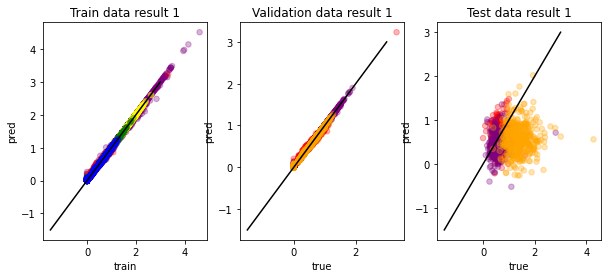

Epoch 16100 Train_loss: 0.026600081  Validation_loss: 0.023793086  Test_loss: 0.7055997 s4d1 loss: 0.33179402 s4d8 loss: 0.38048202 s4d9_loss: 0.9691709 test loss: 0.7055997 cal test 0.7055997455257218
Epoch 16200 Train_loss: 0.0143388705  Validation_loss: 0.013888599  Test_loss: 0.67819285 s4d1 loss: 0.3291183 s4d8 loss: 0.36826044 s4d9_loss: 0.9284824 test loss: 0.67819285 cal test 0.6781928245294812
Epoch 16300 Train_loss: 0.012258678  Validation_loss: 0.0121947825  Test_loss: 0.69298357 s4d1 loss: 0.32980004 s4d8 loss: 0.3743299 s4d9_loss: 0.95073897 test loss: 0.69298357 cal test 0.6929835220319279
Epoch 16400 Train_loss: 0.01218543  Validation_loss: 0.012109854  Test_loss: 0.6931255 s4d1 loss: 0.32998136 s4d8 loss: 0.37447593 s4d9_loss: 0.9508927 test loss: 0.6931255 cal test 0.6931254900972716
Epoch 16500 Train_loss: 0.010458963  Validation_loss: 0.010791158  Test_loss: 0.69134915 s4d1 loss: 0.32979634 s4d8 loss: 0.3738084 s4d9_loss: 0.9482367 test loss: 0.69134915 cal test 0.69

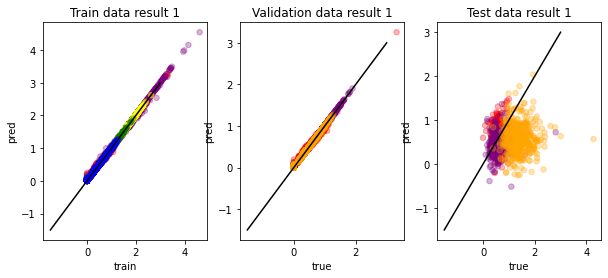

Epoch 17100 Train_loss: 0.01462241  Validation_loss: 0.013892561  Test_loss: 0.6775754 s4d1 loss: 0.3294206 s4d8 loss: 0.3683044 s4d9_loss: 0.9274137 test loss: 0.6775754 cal test 0.6775753003631904
Epoch 17200 Train_loss: 0.008691959  Validation_loss: 0.009324988  Test_loss: 0.6838142 s4d1 loss: 0.3291803 s4d8 loss: 0.37052682 s4d9_loss: 0.9370033 test loss: 0.6838142 cal test 0.6838141661576527
Epoch 17300 Train_loss: 0.0170036  Validation_loss: 0.015847906  Test_loss: 0.67564267 s4d1 loss: 0.32947987 s4d8 loss: 0.3675779 s4d9_loss: 0.9244518 test loss: 0.67564267 cal test 0.6756426970720778
Epoch 17400 Train_loss: 0.011269737  Validation_loss: 0.011050343  Test_loss: 0.6803256 s4d1 loss: 0.32956156 s4d8 loss: 0.36941424 s4d9_loss: 0.93155557 test loss: 0.6803256 cal test 0.6803255946349581
Epoch 17500 Train_loss: 0.0072528827  Validation_loss: 0.008096713  Test_loss: 0.68735623 s4d1 loss: 0.32964975 s4d8 loss: 0.37206668 s4d9_loss: 0.9422397 test loss: 0.68735623 cal test 0.68735621

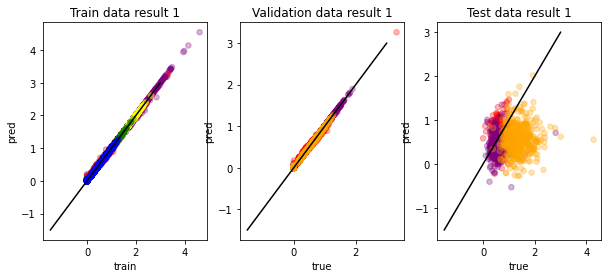

Epoch 18100 Train_loss: 0.0065100486  Validation_loss: 0.007331095  Test_loss: 0.6867406 s4d1 loss: 0.33003128 s4d8 loss: 0.37211704 s4d9_loss: 0.94115484 test loss: 0.6867406 cal test 0.6867405230810308
Epoch 18200 Train_loss: 0.011325582  Validation_loss: 0.010744599  Test_loss: 0.6934278 s4d1 loss: 0.33018792 s4d8 loss: 0.37474418 s4d9_loss: 0.95127296 test loss: 0.6934278 cal test 0.6934278017692174
Epoch 18300 Train_loss: 0.01247176  Validation_loss: 0.011710338  Test_loss: 0.69481856 s4d1 loss: 0.3306577 s4d8 loss: 0.37562245 s4d9_loss: 0.95320684 test loss: 0.69481856 cal test 0.6948184712561638
Epoch 18400 Train_loss: 0.008385259  Validation_loss: 0.008596282  Test_loss: 0.68260807 s4d1 loss: 0.32979867 s4d8 loss: 0.37048122 s4d9_loss: 0.9349349 test loss: 0.68260807 cal test 0.682608021970674
Epoch 18500 Train_loss: 0.007094181  Validation_loss: 0.007532901  Test_loss: 0.68900985 s4d1 loss: 0.3299719 s4d8 loss: 0.37287986 s4d9_loss: 0.94464093 test loss: 0.68900985 cal test 0.

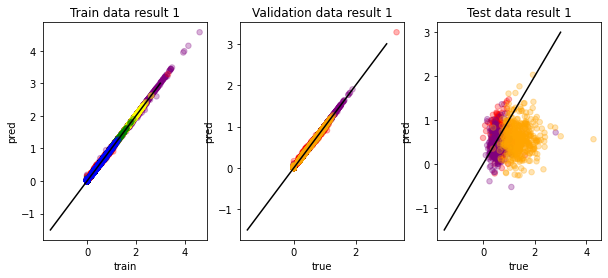

Epoch 19100 Train_loss: 0.018835017  Validation_loss: 0.01699418  Test_loss: 0.6737963 s4d1 loss: 0.33012587 s4d8 loss: 0.36732623 s4d9_loss: 0.92138815 test loss: 0.6737963 cal test 0.6737962726859866
Epoch 19200 Train_loss: 0.0058832834  Validation_loss: 0.0065072672  Test_loss: 0.68825454 s4d1 loss: 0.33033198 s4d8 loss: 0.37292036 s4d9_loss: 0.94334155 test loss: 0.68825454 cal test 0.6882544927343021
Epoch 19300 Train_loss: 0.029730469  Validation_loss: 0.02628128  Test_loss: 0.6658474 s4d1 loss: 0.3308028 s4d8 loss: 0.36484468 s4d9_loss: 0.90898305 test loss: 0.6658474 cal test 0.6658473801754922
Epoch 19400 Train_loss: 0.0056140968  Validation_loss: 0.006242887  Test_loss: 0.6861156 s4d1 loss: 0.3300709 s4d8 loss: 0.37183487 s4d9_loss: 0.9402015 test loss: 0.6861156 cal test 0.6861155969668142
Epoch 19500 Train_loss: 0.0054868124  Validation_loss: 0.0061438004  Test_loss: 0.6873958 s4d1 loss: 0.33014202 s4d8 loss: 0.37224117 s4d9_loss: 0.94214606 test loss: 0.6873958 cal test 0.

In [42]:
num_epochs = 20000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)

In [43]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature, pred_end-pred_start)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_end-pred_start)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

Epoch 0 Train_loss: 0.5739006  Validation_loss: 0.46384948  Test_loss: 0.5247992 s4d1 loss: 0.4762996 s4d8 loss: 0.66280466 s4d9_loss: 0.48666063 test loss: 0.5247992 cal test 0.5248025890431901


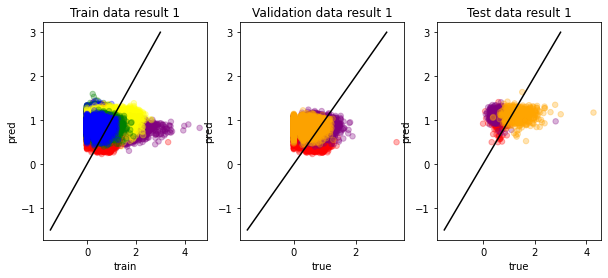

Epoch 100 Train_loss: 0.36812153  Validation_loss: 0.2826153  Test_loss: 0.5943421 s4d1 loss: 0.2243095 s4d8 loss: 0.2840031 s4d9_loss: 0.83462495 test loss: 0.5943421 cal test 0.5943400939760964
Epoch 200 Train_loss: 0.35363394  Validation_loss: 0.27666506  Test_loss: 0.6163195 s4d1 loss: 0.22999537 s4d8 loss: 0.30010113 s4d9_loss: 0.86512804 test loss: 0.6163195 cal test 0.6163176176885089
Epoch 300 Train_loss: 0.34442446  Validation_loss: 0.2742645  Test_loss: 0.62182075 s4d1 loss: 0.23256187 s4d8 loss: 0.3034074 s4d9_loss: 0.87265235 test loss: 0.62182075 cal test 0.6218188248235123


KeyboardInterrupt: 

In [44]:
num_epochs = 20000
learning_rate = 0.001
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)